# Weight-updating EXE simulations

In this notebook, we will use `sampling_simulator` to simulate the sampling in the alchemical space by the Wang-Landau algorithm in an weight-updating expanded ensemble (EXE) simulation.

In [ ]:
import numpy as np
from sampling_simulator import wang_landau_algorithm as wl

In [3]:
params_dict = {
    'n_steps': 200000,
    'wl_ratio': 0.8,
    'wl_scale': 0.7,
    'wl_delta': 10,            # init_wl_delta in GROMACS
    'wl_delta_cutoff': 0.001,   # weight-equil-wl-delta in GROMACS
}

In [6]:
f_ref_whole = np.array([
    0.0, 57.805215366068346, 112.49325354921746, 163.9053804543671, 211.1228680338599, 254.58059732433938, 295.5660812208014,
    334.6531501257331, 371.45476696195874, 406.65593569265764, 439.2891881651442, 469.42891547180665, 497.15580279170484,
    522.4463901739871, 545.4157353241036, 566.0988033555478, 584.5719734781715, 600.4976380135653, 614.3116862505102, 625.6622986339568,
    634.9000108527418, 639.2141393579959, 643.3695667349867, 647.2981063000773, 650.9040500232999, 652.5280053311945, 653.9774650452159, 
    655.178901008137, 656.0135314031018, 656.2533557264542, 656.2030286485515, 655.7434099493724, 654.7837017140891, 653.4171450203427,
    651.8897886531751, 650.4268292093915, 649.155734577982, 647.8279229679827, 646.8756268046341, 645.4731180684097,
], dtype=float)

## Whole-range EXE simulation

In [4]:
t_equil_list, rmse_list = [], []
for i in range(100):
    f_ref = f_ref_whole
    simulator = mock_WL_algorithm(params_dict, f_ref)
    simulator.run()
    t_equil_list.append(simulator.equil_time)
    rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))
    

t_equil = np.mean(t_equil_list)
t_equil_err = np.std(t_equil_list, ddof=1)
rmse = np.mean(rmse_list)
rmse_err = np.std(rmse_list, ddof=1)
comp_cost_rep = []

print('Whole-range EXE simulation')
print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT')

Whole-range EXE simulation
  Equilibration time: 46601 +/- 3129 steps
  RMSE: 0.030 +/- 0.009 kT


## Decoupled EXE replicas

In [5]:
comp_cost = []

In [6]:
# minimum overlap
s = 9
n_sub = 13
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-12
  Equilibration time: 9243 +/- 820 steps
  RMSE: 0.035 +/- 0.011 kT

State range: 9-21
  Equilibration time: 9418 +/- 1074 steps
  RMSE: 0.035 +/- 0.007 kT

State range: 18-30
  Equilibration time: 8574 +/- 635 steps
  RMSE: 0.031 +/- 0.008 kT

State range: 27-39
  Equilibration time: 8776 +/- 1191 steps
  RMSE: 0.036 +/- 0.019 kT

Computational cost: 37672.8 A.U.


In [7]:
s = 8
n_sub = 16
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-15
  Equilibration time: 12981 +/- 948 steps
  RMSE: 0.038 +/- 0.012 kT

State range: 8-23
  Equilibration time: 12640 +/- 1590 steps
  RMSE: 0.027 +/- 0.006 kT

State range: 16-31
  Equilibration time: 11086 +/- 921 steps
  RMSE: 0.028 +/- 0.007 kT

State range: 24-39
  Equilibration time: 11446 +/- 1292 steps
  RMSE: 0.035 +/- 0.015 kT

Computational cost: 51924.0 A.U.


### s = 7

In [8]:
s = 7
n_sub = 19
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-18
  Equilibration time: 16873 +/- 553 steps
  RMSE: 0.029 +/- 0.009 kT

State range: 7-25
  Equilibration time: 15632 +/- 1861 steps
  RMSE: 0.036 +/- 0.013 kT

State range: 14-32
  Equilibration time: 15267 +/- 1906 steps
  RMSE: 0.036 +/- 0.013 kT

State range: 21-39
  Equilibration time: 14196 +/- 1709 steps
  RMSE: 0.036 +/- 0.010 kT

Computational cost: 67492.0 A.U.


In [9]:
s = 6
n_sub = 22
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-21
  Equilibration time: 20681 +/- 910 steps
  RMSE: 0.036 +/- 0.012 kT

State range: 6-27
  Equilibration time: 19823 +/- 2109 steps
  RMSE: 0.034 +/- 0.012 kT

State range: 12-33
  Equilibration time: 17828 +/- 2095 steps
  RMSE: 0.036 +/- 0.009 kT

State range: 18-39
  Equilibration time: 17798 +/- 1083 steps
  RMSE: 0.032 +/- 0.012 kT

Computational cost: 82723.6 A.U.


In [10]:
s = 5
n_sub = 25
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-24
  Equilibration time: 24932 +/- 1275 steps
  RMSE: 0.041 +/- 0.016 kT

State range: 5-29
  Equilibration time: 24263 +/- 1245 steps
  RMSE: 0.032 +/- 0.007 kT

State range: 10-34
  Equilibration time: 22019 +/- 1779 steps
  RMSE: 0.036 +/- 0.015 kT

State range: 15-39
  Equilibration time: 20107 +/- 2169 steps
  RMSE: 0.032 +/- 0.005 kT

Computational cost: 99726.4 A.U.


In [11]:
s = 4
n_sub = 28
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-27
  Equilibration time: 29455 +/- 1776 steps
  RMSE: 0.030 +/- 0.005 kT

State range: 4-31
  Equilibration time: 28252 +/- 2010 steps
  RMSE: 0.029 +/- 0.005 kT

State range: 8-35
  Equilibration time: 26300 +/- 2063 steps
  RMSE: 0.028 +/- 0.008 kT

State range: 12-39
  Equilibration time: 26240 +/- 1974 steps
  RMSE: 0.028 +/- 0.006 kT

Computational cost: 117819.2 A.U.


In [12]:
s = 3
n_sub = 31
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-30
  Equilibration time: 32414 +/- 2359 steps
  RMSE: 0.041 +/- 0.018 kT

State range: 3-33
  Equilibration time: 31859 +/- 2704 steps
  RMSE: 0.031 +/- 0.011 kT

State range: 6-36
  Equilibration time: 31354 +/- 2551 steps
  RMSE: 0.032 +/- 0.010 kT

State range: 9-39
  Equilibration time: 30397 +/- 2659 steps
  RMSE: 0.040 +/- 0.016 kT

Computational cost: 129656.4 A.U.


In [13]:
s = 2
n_sub = 34
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-33
  Equilibration time: 37915 +/- 2469 steps
  RMSE: 0.032 +/- 0.010 kT

State range: 2-35
  Equilibration time: 36342 +/- 2536 steps
  RMSE: 0.037 +/- 0.012 kT

State range: 4-37
  Equilibration time: 37412 +/- 2370 steps
  RMSE: 0.031 +/- 0.006 kT

State range: 6-39
  Equilibration time: 34024 +/- 2614 steps
  RMSE: 0.033 +/- 0.008 kT

Computational cost: 151659.6 A.U.


In [14]:
s = 1
n_sub = 37
t_equil_all = []
for i in range(4):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

comp_cost.append(max(t_equil_all) * 4)
print(f'Computational cost: {max(t_equil_all) * 4} A.U.')

State range: 0-36
  Equilibration time: 42572 +/- 2457 steps
  RMSE: 0.033 +/- 0.012 kT

State range: 1-37
  Equilibration time: 40070 +/- 2730 steps
  RMSE: 0.032 +/- 0.013 kT

State range: 2-38
  Equilibration time: 40819 +/- 2762 steps
  RMSE: 0.031 +/- 0.007 kT

State range: 3-39
  Equilibration time: 41454 +/- 2717 steps
  RMSE: 0.033 +/- 0.008 kT

Computational cost: 170287.6 A.U.


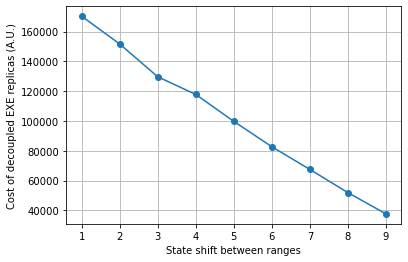

In [23]:
s = range(1, 10)
comp_cost.reverse()

plt.figure()
plt.plot(s, comp_cost, marker='o')
plt.xlabel('State shift between ranges')
plt.ylabel('Cost of decoupled EXE replicas (A.U.)')
plt.grid()

So, it's clear that with the same number of replicas, the fewer the replicas, the lower the computational cost. Here, we explore decoupled EXE replicas with other numbers of replicas and minimal overlap. (With `n_sim=1`, the computational cost was just the cost of the whole-range EXE simulation, i.e., 46767 A.U.) 

In [21]:
comp_cost_rep = []

### n_sim = 2, s=19, n_sub=21

In [28]:
s = 19
n_sub = 21
n_sim = 2
t_equil_all = []
for i in range(n_sim):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

print(f'Computational cost: {max(t_equil_all) * n_sim} A.U.')

State range: 0-20
  Equilibration time: 19042 +/- 1705 steps
  RMSE: 0.034 +/- 0.015 kT

State range: 19-39
  Equilibration time: 16486 +/- 1663 steps
  RMSE: 0.029 +/- 0.009 kT

Computational cost: 38083.0 A.U.


### n_sim = 3, s=13, n_sub=14

In [29]:
s = 13
n_sub = 14
n_sim = 3
t_equil_all = []
for i in range(n_sim):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

print(f'Computational cost: {max(t_equil_all) * n_sim} A.U.')

State range: 0-13
  Equilibration time: 10616 +/- 837 steps
  RMSE: 0.035 +/- 0.009 kT

State range: 13-26
  Equilibration time: 9215 +/- 1001 steps
  RMSE: 0.044 +/- 0.013 kT

State range: 26-39
  Equilibration time: 9290 +/- 899 steps
  RMSE: 0.036 +/- 0.018 kT

Computational cost: 31849.5 A.U.


### n_sim=5, s=7, n_sub=12

In [30]:
s = 7
n_sub = 12
n_sim = 5
t_equil_all = []
for i in range(n_sim):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

print(f'Computational cost: {max(t_equil_all) * n_sim} A.U.')

State range: 0-11
  Equilibration time: 8257 +/- 718 steps
  RMSE: 0.038 +/- 0.016 kT

State range: 7-18
  Equilibration time: 7984 +/- 1243 steps
  RMSE: 0.032 +/- 0.007 kT

State range: 14-25
  Equilibration time: 7693 +/- 491 steps
  RMSE: 0.040 +/- 0.017 kT

State range: 21-32
  Equilibration time: 6851 +/- 683 steps
  RMSE: 0.042 +/- 0.016 kT

State range: 28-39
  Equilibration time: 7490 +/- 661 steps
  RMSE: 0.032 +/- 0.013 kT

Computational cost: 41286.5 A.U.


### n_sim=6, s=6, n_sub=10

In [31]:
s = 6
n_sub = 10
n_sim = 6
t_equil_all = []
for i in range(n_sim):
    t_equil_list, rmse_list = [], []
    for j in range(10):
        f_ref = f_ref_whole[i * s : i * s + n_sub]
        simulator = mock_WL_algorithm(params_dict, f_ref)
        simulator.run()
        t_equil_list.append(simulator.equil_time)
        rmse_list.append(calc_rmse(simulator.g, f_ref - f_ref[0]))


    t_equil = np.mean(t_equil_list)
    t_equil_err = np.std(t_equil_list, ddof=1)
    rmse = np.mean(rmse_list)
    rmse_err = np.std(rmse_list, ddof=1)
    t_equil_all.append(t_equil)

    print(f'State range: {i * s}-{i * s + n_sub - 1}')
    print(f'  Equilibration time: {t_equil:.0f} +/- {t_equil_err:.0f} steps')
    print(f'  RMSE: {rmse:.3f} +/- {rmse_err:.3f} kT\n')

print(f'Computational cost: {max(t_equil_all) * n_sim} A.U.')

State range: 0-9
  Equilibration time: 6474 +/- 674 steps
  RMSE: 0.042 +/- 0.019 kT

State range: 6-15
  Equilibration time: 6277 +/- 729 steps
  RMSE: 0.034 +/- 0.011 kT

State range: 12-21
  Equilibration time: 6080 +/- 994 steps
  RMSE: 0.038 +/- 0.013 kT

State range: 18-27
  Equilibration time: 5395 +/- 809 steps
  RMSE: 0.040 +/- 0.021 kT

State range: 24-33
  Equilibration time: 5721 +/- 848 steps
  RMSE: 0.037 +/- 0.010 kT

State range: 30-39
  Equilibration time: 5574 +/- 887 steps
  RMSE: 0.031 +/- 0.011 kT

Computational cost: 38841.600000000006 A.U.


Text(0, 0.5, 'Computational cost (A.U.)')

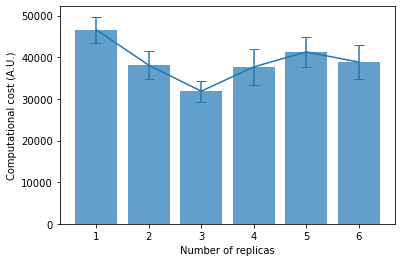

In [40]:
n_sim = [1, 2, 3, 4, 5, 6]
cost = [46601, 38083, 31849, 37673, 41287, 38841]
cost_err = [3129, 1705 * 2, 837 * 3, 1074 * 4, 718 * 5, 674 * 6]
plt.figure()
plt.bar(n_sim, cost, alpha=0.7)
plt.errorbar(n_sim, cost, yerr=cost_err, capsize=5)
plt.xlabel('Number of replicas')
plt.ylabel('Computational cost (A.U.)')